In [221]:
import sys
sys.path.append('..')
import os, pickle, torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

root = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE_FCNN'

In [86]:
hps = []
scalars = []
for dir in os.listdir(root):
    tfn = [f for f in os.listdir(root + f'/{dir}') if 'event' in f][0]
    hps.append(dir)
    with open(f'{root}/{dir}/best_epoch.txt') as f:
        f.read()
    scalars.append([ea.Scalars('Best valid loss')[-1].step, ea.Scalars('Best valid loss')[-1].value])
hps = np.array(hps)
scalars = np.array(scalars)

In [126]:
feature_type = np.array([hp.replace('tf_','').split('_batch_')[0] for hp in hps])
le = LabelEncoder()
fti = le.fit_transform(feature_type)
ldim, edim, el, ddim, dl = np.array([hp.split('_mdim_')[1].replace('-','_').split('_') for hp in hps]).astype(int).T
epoch, loss = scalars.T

In [141]:
loss[fti == 0]

array([0.11086488, 0.11078785, 0.11247338, 0.10959208, 0.11316311,
       0.11307292])

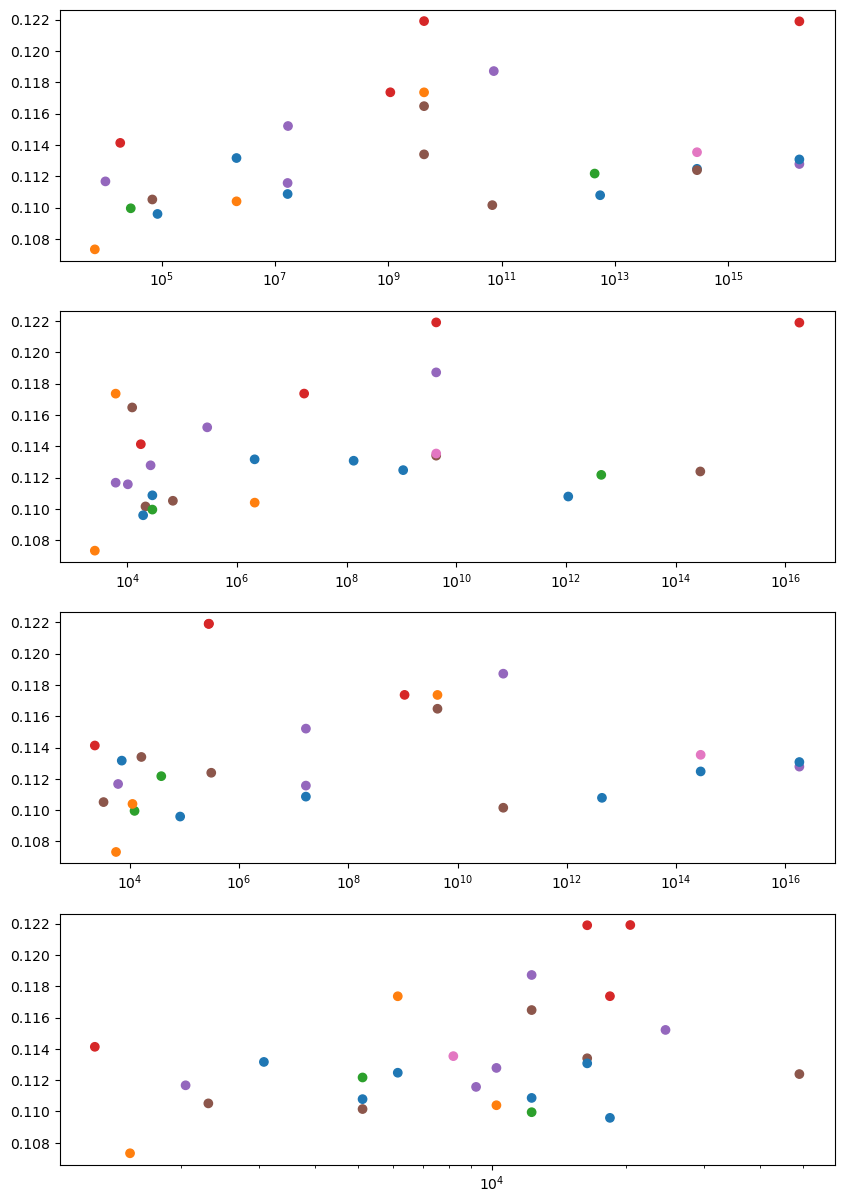

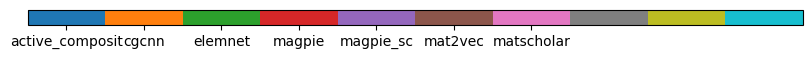

In [166]:
f, axs = plt.subplots(4,1,figsize=(10,15))
for ax in axs: 
    ax.set_xscale('log')
#    l = 6
#    for k in loss[fti == l]:
#        ax.axhline(k, color=mpl.cm.tab10(l))
cm = axs[0].scatter(np.power(edim, el) + np.power(ddim, dl) + ldim * (edim + ddim), loss, c=fti, cmap='tab10', vmax=10)
axs[1].scatter(np.power(edim, el) + ldim * (edim + ddim), loss, c=fti, cmap='tab10', vmax=10)
axs[2].scatter(np.power(ddim, dl) + ldim * (edim + ddim), loss, c=fti, cmap='tab10', vmax=10)
axs[3].scatter(ldim * (edim + ddim), loss, c=fti, cmap='tab10', vmax=10)
f, ax = plt.subplots(1,1,figsize=(10,0.2))
plt.colorbar(cm, cax=ax, orientation='horizontal')
ax.set_xticks(le.fit_transform(le.classes_) + 0.5, labels=le.classes_)

In [222]:
output = {}
for dir in os.listdir(root):
    output[dir] = {
        'test' :pickle.load(open(os.path.join(root, dir, 'best.output.test.pkl'), 'rb')),
        'valid':pickle.load(open(os.path.join(root, dir, 'best.output.valid.pkl'), 'rb')),
    }
    break

In [227]:
o = output['oliynyk_sc_batch_0256_mdim_32_128_2_064_2']['valid']

In [228]:
from src.feature import feature_to_ligand_index, ligand_composit_feature, ligand_label, ligand_index, ligand_vector
from src.utils import squared_error, cosin_similarity

def feature_to_nearest_ligand(vec, ref, alpha=0.5):
    alpha = np.clip(alpha, 0, 1)
    sser = squared_error(vec, ref, False)
    csim = cosin_similarity(vec, ref, False)
    return (1 - alpha) * sser + alpha * (1 - csim), sser, csim

In [236]:
tol = 0.5
input_index = np.array(feature_to_ligand_index(o['input']))
pred_index = np.array(feature_to_ligand_index(o['pred'], tol=0.5))
input_label = np.array([ligand_index[i] for i in input_index])
pred_label = np.array([ligand_index[i] if i != -1 else 'Fail' for i in pred_index])

array(['Metal-N-O', 'Metal-N-O', 'Metal-C-O', ..., 'Metal-F', 'Metal-F',
       'Metal-O'], dtype='<U15')

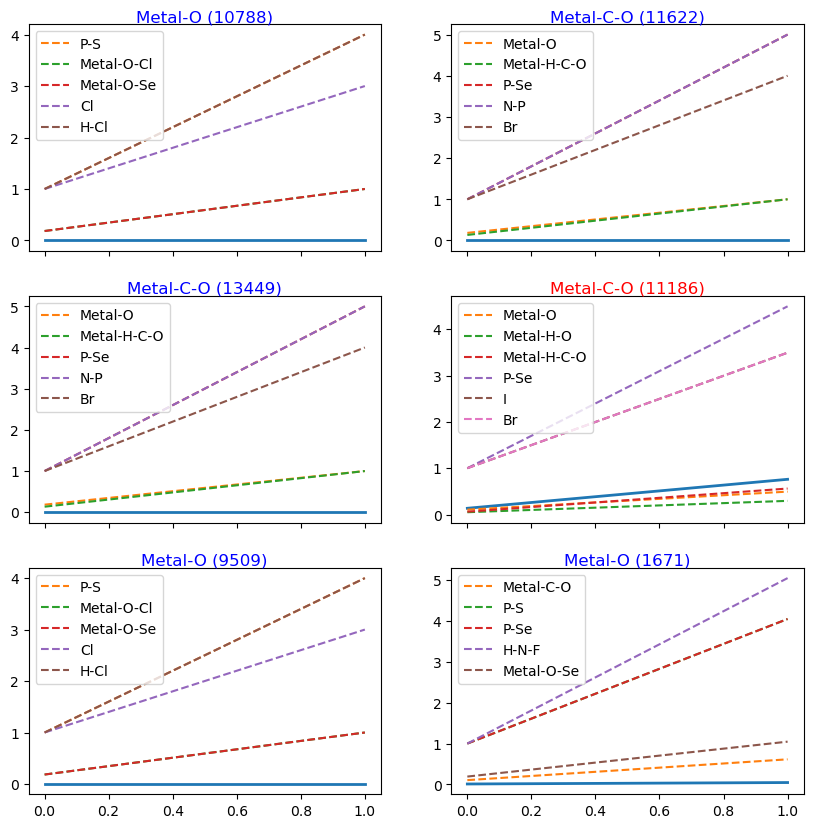

In [243]:
f, axs = plt.subplots(3,2,figsize=(10,10), sharex=True)
for i, ax in zip(np.random.randint(0, len(input_index), 6), axs.reshape(-1)):
    i_prd = pred_index[i]
    i_inp = input_index[i]
    ax.set_title(ligand_index[i_inp] + f' ({i})', color='red' if i_prd != i_inp else 'blue', pad=-1)
    sser = squared_error(o['pred'][i].reshape(1,-1), ligand_vector, average=False)
    csim = cosin_similarity(o['pred'][i].reshape(1,-1), ligand_vector, average=False)
    ys = np.array([k * sser + (5 - k) * (1 - csim) for k in range(6)]).T * 0.2
    x = np.linspace(0,1,6)
    ax.plot(x, ys[i_inp], lw=2)
    for j in sorted(np.unique(np.hstack([np.argsort(sser)[:3], np.argsort(csim)[:3]]))):
        if j == i_inp: continue
        ax.plot(x, ys[j], ls='--', label=ligand_index[j])
    ax.legend(loc='upper left')


In [36]:
pred_index[4554], input_index[4554]

(0, 0)

In [49]:
for i_inp in sorted(np.unique(input_index), key=lambda x: ligand_index[x]):
    m = input_index == i_inp
    a = np.sum(pred_index[m] == i_inp)
    t = np.sum(m)
    print('{:15s} {:5d} {:5d} {:8.3f}'.format(ligand_index[i_inp], t, a, 100*a/t))
    
#    print(sorted(zip(*np.unique(np.array(pred_label)[m], return_counts=True)), key=lambda x: x[1], reverse=True))

C                   7     7  100.000
H-C-N-O             2     0    0.000
H-C-O               6     0    0.000
H-C-S-Br            3     0    0.000
H-C-S-Cl            3     0    0.000
H-C-S-I             4     0    0.000
H-N-Cl             19    12   63.158
H-N-F               2     0    0.000
H-N-O-P            18    18  100.000
H-N-O-S             5     0    0.000
H-O-P               8     0    0.000
Metal            1518  1466   96.574
Metal-Br           10     2   20.000
Metal-C             4     0    0.000
Metal-C-O        1572  1448   92.112
Metal-C-S           1     0    0.000
Metal-Cl           23     5   21.739
Metal-F            36    14   38.889
Metal-H-C-N-Br      1     0    0.000
Metal-H-C-N-Cl      1     0    0.000
Metal-H-C-N-I       1     0    0.000
Metal-H-C-O        90     0    0.000
Metal-H-F           1     0    0.000
Metal-H-N-O        28     3   10.714
Metal-H-O          97    15   15.464
Metal-H-O-P        10     0    0.000
Metal-H-O-S         2     0    0.000
M

In [213]:
from src.networks import BaseNetwork

class Base:
    def __init__(self, *args, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class TestA(Base):
    def __init__(self, n_dim, n_layer=4):
        super().__init__(n_dim=n_dim, n_layer=n_layer)
        self.n_dim *= 2

    def set_a(self, x):
        self.a = x

class TestB(TestA):
    def __init__(self, n_dim, n_layer=3):
        super().__init__(n_dim=n_dim, n_layer=n_layer)
        self.n_dim *= 3
    
    def set_b(self, x):
        self.b = x

class TestC(TestB):
    def __init__(self, n_dim, n_layer=2, t=5):
        super(TestA, self).__init__(n_dim=n_dim, n_layer=n_layer, t=t)

class TestD(TestB):
    def __init__(self, n_dim, n_layer=1, t=5):
        super(TestB, self).__init__(n_dim=n_dim, n_layer=n_layer, t=t)

class TestE(TestB):
    def __init__(self, n_dim, n_layer=0, t=5):
        super().__init__(n_dim=n_dim, n_layer=n_layer, t=t)

print(TestA(4).n_dim, TestA(4).n_layer, hasattr(TestA, 'set_a'), hasattr(TestA, 'set_b'))
print(TestB(4).n_dim, TestB(4).n_layer, hasattr(TestB, 'set_a'), hasattr(TestB, 'set_b'))
print(TestC(4).n_dim, TestC(4).n_layer, hasattr(TestC, 'set_a'), hasattr(TestC, 'set_b'))
print(TestD(4).n_dim, TestD(4).n_layer, hasattr(TestD, 'set_a'), hasattr(TestD, 'set_b'))
print(TestE(4).n_dim, TestE(4).n_layer, hasattr(TestE, 'set_a'), hasattr(TestE, 'set_b'))

8 4 True False
24 3 True True
4 2 True True


TypeError: __init__() got an unexpected keyword argument 't'

In [214]:
torch

NameError: name 'torch' is not defined